In [327]:
import os, sys, collections, re, json, io, base64
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as ts
import warnings
import scipy
import IPython
import sklearn

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
from pandas import Series
from IPython.display import display, Math, Latex
from IPython.external import mathjax
from scipy import stats
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series
import quantstats

In [328]:
# EIA Inventory Data (df)
dfInventory = pd.read_excel('http://ir.eia.gov/wpsr/psw01.xls', "Data 1", index_col="Date", parse_dates=["Date"], skiprows=2)

dfSpot = pd.read_csv('Crude Oil WTI Futures Historical Data.csv',index_col = 'Date',parse_dates = ['Date'])

dfSpot_W = pd.read_csv('Crude Oil WTI Futures Historical Data_week.csv',index_col = 'Date',parse_dates = ['Date'])





In [329]:
dfInventory = dfInventory["2011":]


In [330]:
dfInventory_cols = ['crude_oil','crude_oil_no_spr','crude_in_spr',
                    'gasoline','reformulated_gasoline','conventional_gasoline','blending_gasoline',
                    'fuel_ethanol','jet_fuel','distillate', 'distillate_15ppm','distillate_500ppm',
                    'distillate_500+ppm','residual_oil','propane_propylene','other_oils','unfinished_oils',
                    'Inventory','crude_products_no_spr']

In [331]:
dfInventory.columns = dfInventory_cols 

In [332]:
dfInventory

,crude_oil,crude_oil_no_spr,crude_in_spr,gasoline,reformulated_gasoline,conventional_gasoline,blending_gasoline,fuel_ethanol,jet_fuel,distillate,distillate_15ppm,distillate_500ppm,distillate_500+ppm,residual_oil,propane_propylene,other_oils,unfinished_oils,Inventory,crude_products_no_spr
Date,,,,,,,,,,,,,,,,,,,
2011-01-07,1038071,311526,726545,223227.0,328.0,66790.0,156110.0,17096.0,44094,164759,107866.0,12545.0,44347.0,39418,NaN,192352.0,76946,1769567.0,1043022.0
2011-01-14,1040687,314143,726544,227670.0,324.0,66496.0,160850.0,17801.0,43087,165797,109678.0,12580.0,43538.0,41837,NaN,189910.0,77675,1771930.0,1045386.0
2011-01-21,1045523,318979,726544,230074.0,318.0,66785.0,162971.0,19037.0,42748,165657,112093.0,11587.0,41977.0,41654,NaN,187839.0,76956,1774326.0,1047782.0
2011-01-28,1048117,321573,726544,236228.0,318.0,68225.0,167685.0,18890.0,43769,164078,113535.0,11375.0,39168.0,40141,NaN,190713.0,81067,1779865.0,1053321.0
2011-02-04,1049948,323404,726544,240891.0,587.0,71466.0,168838.0,19576.0,42938,164366,115255.0,10468.0,38644.0,39147,NaN,191303.0,82507,1782974.0,1056430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-09,1058884,437580,621304,236535.0,22.0,20761.0,215752.0,21134.0,44390,142349,130750.0,3260.0,8338.0,30630,59563.0,298673.0,91187,1892157.0,1270853.0
2021-07-16,1060991,439687,621304,236414.0,18.0,18428.0,217968.0,22518.0,44974,141000,128650.0,3424.0,8926.0,28659,62655.0,299370.0,90518,1896581.0,1275277.0
2021-07-23,1056902,435598,621304,234161.0,21.0,18034.0,216106.0,22733.0,45053,137912,125526.0,3352.0,9033.0,29399,64517.0,299452.0,91473,1890130.0,1268826.0


In [333]:
dfSpot = dfSpot['2011':]
dfSpot

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-03,91.55,91.31,92.58,91.21,225.19K,0.19%
2011-01-04,89.38,91.50,92.07,88.36,415.52K,-2.37%
2011-01-05,90.30,89.29,90.84,88.10,416.91K,1.03%
2011-01-06,88.38,90.47,90.71,87.85,440.46K,-2.13%
2011-01-07,88.03,88.18,89.48,87.25,444.81K,-0.40%
...,...,...,...,...,...,...
2021-07-30,73.95,73.41,74.23,72.93,303.70K,0.45%
2021-08-02,71.26,73.91,73.95,70.55,448.20K,-3.64%
2021-08-03,70.56,71.52,71.96,69.19,509.94K,-0.98%


In [334]:
dfSpot_W = dfSpot_W['2011':]
dfSpot_W = dfSpot_W[1:]
dfSpot_W

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-09,91.54,89.00,92.39,88.13,1.91M,3.99%
2011-01-16,89.11,91.51,92.10,88.00,635.23K,-2.65%
2011-01-23,89.34,89.26,89.73,85.11,2.00M,0.26%
2011-01-30,89.03,89.97,92.84,88.40,1.79M,-0.35%
2011-02-06,85.58,89.06,89.54,85.10,1.91M,-3.88%
...,...,...,...,...,...,...
2021-07-04,74.56,75.35,76.98,70.76,1.85M,-0.80%
2021-07-11,71.81,74.74,75.52,70.41,1.74M,-3.69%
2021-07-18,72.07,71.49,72.21,65.21,1.05M,0.36%


In [335]:
import copy
test = copy.deepcopy(dfInventory.crude_oil_no_spr)

In [336]:
import statsmodels.api as sm
m2_add = sm.tsa.seasonal_decompose(test,model='additive', extrapolate_trend='freq')
m2_mult = sm.tsa.seasonal_decompose(test,model='multiplicative', extrapolate_trend='freq')

In [337]:
from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go
from plotly import subplots
#setting offilne
plotly.offline.init_notebook_mode(connected=True)

# 库存

In [344]:
trace0 = go.Scatter(
    x = m2_mult.trend.index,
    y = m2_mult.trend,
    name = '美国原油库存季调'
)
trace1 = go.Scatter(
    x = dfInventory.index,
    y = dfInventory.crude_oil_no_spr,
    
    name = '美国原油库存'
)
trace2 = go.Scatter(
    x = dfSpot_W.index,
    y = dfSpot_W.Price,
    yaxis="y2",
    name = '周度油价'
)
data = [trace1,trace2]
layout = go.Layout(title='对比',
                   yaxis=dict(title="库存"),
                   yaxis2=dict(title="周度油价", overlaying='y', side="right"),
                   legend=dict(x=0, y=1, font=dict(size=12, color="black")))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [340]:
trace0 = go.Scatter(
    x = m2_mult.trend.index,
    y = m2_mult.trend,
    name = '美国原油库存季调'
)
trace1 = go.Scatter(
    x = dfInventory.index,
    y = dfInventory.crude_oil_no_spr,
    
    name = '美国原油库存'
)
trace2 = go.Scatter(
    x = dfSpot_W.index,
    y = dfSpot_W.Price,
    yaxis="y2",
    name = '周度油价'
)
data = [trace0,trace2]
layout = go.Layout(title='对比',
                   yaxis=dict(title="季调库存"),
                   yaxis2=dict(title="周度油价", overlaying='y', side="right"),
                   legend=dict(x=0, y=1, font=dict(size=12, color="black")))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [341]:
adjusted_inventory = m2_mult.trend

In [342]:
short_term = adjusted_inventory.pct_change(2)
long_term = adjusted_inventory.pct_change(16)

In [343]:
trace0 = go.Scatter(
    x = short_term.index,
    y = short_term,
    name = '短期库存变化速率'
)
trace1 = go.Scatter(
    x = long_term.index,
    y = long_term,
    
    name = '长期库存变化速率'
)
trace2 = go.Scatter(
    x = dfSpot_W.index,
    y = dfSpot_W.Price,
    yaxis="y2",
    name = '周度油价'
)
data = [trace0,trace1,trace2]
layout = go.Layout(title='对比',
                   yaxis=dict(title="速率"),
                   yaxis2=dict(title="周度油价", overlaying='y', side="right"),
                   legend=dict(x=0, y=1, font=dict(size=12, color="black")))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [228]:
long_term

Date
2011-01-07         NaN
2011-01-14         NaN
2011-01-21         NaN
2011-01-28         NaN
2011-02-04         NaN
                ...   
2021-07-02    0.015520
2021-07-09    0.015505
2021-07-16    0.015490
2021-07-23    0.015475
2021-07-30    0.015460
Name: trend, Length: 552, dtype: float64

In [229]:
short_term

Date
2011-01-07         NaN
2011-01-14         NaN
2011-01-21    0.001566
2011-01-28    0.001565
2011-02-04    0.001564
                ...   
2021-07-02    0.001914
2021-07-09    0.001912
2021-07-16    0.001910
2021-07-23    0.001909
2021-07-30    0.001907
Name: trend, Length: 552, dtype: float64

In [391]:
dfSpot_W.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-09,91.54,89.00,92.39,88.13,1.91M,3.99%
2011-01-16,89.11,91.51,92.10,88.00,635.23K,-2.65%
2011-01-23,89.34,89.26,89.73,85.11,2.00M,0.26%
2011-01-30,89.03,89.97,92.84,88.40,1.79M,-0.35%
2011-02-06,85.58,89.06,89.54,85.10,1.91M,-3.88%


# 宏观

In [346]:
USDX_W = pd.read_csv('US Dollar Index Historical Data.csv',index_col = 'Date',parse_dates = ['Date'])
USDX_d = pd.read_csv('US Dollar Index Historical Data_daily.csv',index_col = 'Date',parse_dates = ['Date'])
USDX_d['同比增长'] = USDX_d['Price'].pct_change(252)

In [347]:
dfSpot_W

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-09,91.54,89.00,92.39,88.13,1.91M,3.99%
2011-01-16,89.11,91.51,92.10,88.00,635.23K,-2.65%
2011-01-23,89.34,89.26,89.73,85.11,2.00M,0.26%
2011-01-30,89.03,89.97,92.84,88.40,1.79M,-0.35%
2011-02-06,85.58,89.06,89.54,85.10,1.91M,-3.88%
...,...,...,...,...,...,...
2021-07-04,74.56,75.35,76.98,70.76,1.85M,-0.80%
2021-07-11,71.81,74.74,75.52,70.41,1.74M,-3.69%
2021-07-18,72.07,71.49,72.21,65.21,1.05M,0.36%


In [349]:
import datetime

# 美元指数

In [350]:
test_index = pd.Series(dfSpot_W.index).apply(lambda x: x + datetime.timedelta(days=-2))
target_USD = USDX_d.loc[list(test_index.apply(lambda x: str(x).split(' ')[0])),:]
target_USD

,Price,Open,High,Low,Vol.,Change %,同比增长
Date,,,,,,,
2011-01-07,81.01,80.87,81.14,80.69,-,0.27%,0.034082
2011-01-14,79.16,79.20,79.41,78.81,-,-0.04%,0.006229
2011-01-21,78.21,78.89,78.91,78.10,-,-0.77%,-0.014615
2011-01-28,78.13,77.78,78.28,77.61,-,0.51%,-0.023741
2011-02-04,78.04,77.80,78.22,77.56,-,0.37%,-0.029112
...,...,...,...,...,...,...,...
2021-07-02,92.23,92.57,92.74,92.18,-,-0.40%,-0.040071
2021-07-09,92.13,92.36,92.54,92.09,-,-0.31%,-0.030108
2021-07-16,92.69,92.59,92.76,92.53,-,0.07%,-0.008133


In [353]:
trace0 = go.Scatter(
    x = target_USD['同比增长'].index,
    y = target_USD['同比增长'],
    name = '美元指数同比',
    yaxis="y2",
)
trace1 = go.Scatter(
    x = dfInventory.index,
    y = dfInventory.crude_oil_no_spr,
    
    name = '美国原油库存'
)
trace2 = go.Scatter(
    x = dfSpot_W.index,
    y = dfSpot_W.Price,
    
    name = '周度油价'
)
data = [trace0,trace2]
layout = go.Layout(title='对比',
                   yaxis=dict(title="油价"),
                   yaxis2=dict(title="美元指数", overlaying='y', side="right"),
                   legend=dict(x=0, y=1, font=dict(size=12, color="black")))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [83]:
signal_together.head()

,price,stock_short_term_signal,stock_long_term_signal,USD_signal,spread_signal,close,open,high,low
Date,,,,,,,,,
2011-04-28,112.86,0,0,0,1,112.86,112.86,112.86,112.86
2011-05-05,100.34,0,0,0,1,100.34,100.34,100.34,100.34
2011-05-12,99.23,0,0,0,0,99.23,99.23,99.23,99.23
2011-05-19,99.47,0,0,0,1,99.47,99.47,99.47,99.47
2011-05-26,100.23,0,0,0,0,100.23,100.23,100.23,100.23


In [254]:
import backtrader as bt
from backtrader.feeds import GenericCSVData

signal_together = pd.read_csv('信号集合 (1).csv',encoding = 'utf_8_sig',index_col = ['Date'],parse_dates = ['Date'])
signal_together = signal_together['2011-04-21':]

signal_together.columns = ['price','stock_short_term_signal','stock_long_term_signal','USD_signal','spread_signal']
signal_together['close'] = signal_together['open'] = signal_together['high'] = signal_together['low'] = signal_together['price']

signal_together1 = signal_together[['close','open','high','low']]
signal_together2 = signal_together[['stock_short_term_signal','stock_long_term_signal','USD_signal','spread_signal']]
#signal_together['datetime'] = signal_together.index
#signal_together.index = day_data.index[:537]
signal_together


,price,stock_short_term_signal,stock_long_term_signal,USD_signal,spread_signal,close,open,high,low
Date,,,,,,,,,
2011-04-21,112.29,-1.0,-1.0,1.0,1.0,112.29,112.29,112.29,112.29
2011-04-28,112.86,-1.0,-1.0,1.0,1.0,112.86,112.86,112.86,112.86
2011-05-05,100.34,-1.0,-1.0,1.0,-1.0,100.34,100.34,100.34,100.34
2011-05-12,99.23,-1.0,-1.0,1.0,1.0,99.23,99.23,99.23,99.23
2011-05-19,99.47,-1.0,-1.0,1.0,-1.0,99.47,99.47,99.47,99.47
...,...,...,...,...,...,...,...,...,...
2021-07-08,73.23,-1.0,-1.0,1.0,-1.0,73.23,73.23,73.23,73.23
2021-07-15,71.49,-1.0,-1.0,1.0,1.0,71.49,71.49,71.49,71.49
2021-07-22,71.71,-1.0,-1.0,1.0,-1.0,71.71,71.71,71.71,71.71


In [375]:
class TestStrategy(bt.Strategy):
    params = (('max_hold', 700000),)
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(str(dt), txt, ',position size',self.position.size)
        
    def __init__(self):
        self.dataclose = self.datas[0].price
        self.stock_short_term_signal = self.datas[0].stock_short_term_signal
        self.stock_long_term_signal = self.datas[0].stock_long_term_signal
        self.USD_signal = self.datas[0].USD_signal
        self.spread_signal = self.datas[0].spread_signal
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.val_start = self.broker.get_cash()
        
    def notify_cashvalue(self, cash, value):
        self.vals = value
        print('PnL' + str(self.vals - self.val_start))  

            
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        if len(self.dataclose) == 537:
            self.close(exectype = bt.Order.Market)
            return
            
        if self.order:
            return
        if self.position.size == self.params.max_hold:
            self.close(exectype = bt.Order.Close)
            return
            
        
        if self.position.size == -self.params.max_hold:
            self.close(exectype = bt.Order.Close)
            return
        stock_signal = 0
        if self.stock_short_term_signal == -1 and self.stock_short_term_signal == -1:
            stock_signal = -1
        if self.stock_short_term_signal == 1 and self.stock_short_term_signal == -1:
            stock_signal = 1
        if self.stock_short_term_signal == 1:
            stock_signal = 1
        signal_now = stock_signal + self.USD_signal + self.spread_signal
        if signal_now > 0:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.order = self.buy(exectype=bt.Order.Close,size=70000,coc=True)
            
        elif signal_now < 0:
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.order = self.sell(exectype=bt.Order.Close,size=70000,coc=True)
                
                
        
           

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    

In [376]:
class PandasData_more(bt.feeds.PandasData):
    lines = ('price', 'stock_short_term_signal','stock_long_term_signal','USD_signal','spread_signal' ) # 要添加的线
    # 设置 line 在数据源上的列位置
    params=(
        ('price','price'),
        ('stock_short_term_signal','stock_short_term_signal'),
        ('stock_long_term_signal','stock_long_term_signal'),
        ('USD_signal','USD_signal'),
        ('spread_signal','spread_signal'),
           ) 

In [384]:
import datetime

cerebro = bt.Cerebro() 
datafeed1 = PandasData_more(dataname=signal_together, 
                            fromdate=signal_together.index[0], 
                            todate=signal_together.index[-1])

cerebro.broker.setcash(10000000.0)
cerebro.broker.setcommission(commission=0.001) 
cerebro.adddata(datafeed1)
cerebro.addstrategy(TestStrategy)
rasult = cerebro.run()

PnL0.0
2011-04-21 Close, 112.29 ,position size 0
2011-04-21 BUY CREATE, 112.29 ,position size 0
2011-04-28 BUY EXECUTED, Price: 112.86, Cost: 7900200.00, Comm 7900.20 ,position size 70000
PnL-7900.199999999255
2011-04-28 Close, 112.86 ,position size 70000
2011-04-28 BUY CREATE, 112.86 ,position size 70000
2011-05-05 Order Canceled/Margin/Rejected ,position size 70000
PnL-884300.1999999993
2011-05-05 Close, 100.34 ,position size 70000
2011-05-05 SELL CREATE, 100.34 ,position size 70000
2011-05-12 SELL EXECUTED, Price: 99.23, Cost: 7900200.00, Comm 6946.10 ,position size 0
2011-05-12 OPERATION PROFIT, GROSS -954100.00, NET -968946.30 ,position size 0
PnL-968946.2999999989
2011-05-12 Close, 99.23 ,position size 0
2011-05-12 BUY CREATE, 99.23 ,position size 0
2011-05-19 BUY EXECUTED, Price: 99.47, Cost: 6962900.00, Comm 6962.90 ,position size 70000
PnL-975909.1999999993
2011-05-19 Close, 99.47 ,position size 70000
2011-05-19 SELL CREATE, 99.47 ,position size 70000
2011-05-26 SELL EXECUTED,

2013-08-08 Order Canceled/Margin/Rejected ,position size 0
PnL-3086426.0000000047
2013-08-08 Close, 103.88 ,position size 0
2013-08-08 SELL CREATE, 103.88 ,position size 0
2013-08-15 SELL EXECUTED, Price: 106.90, Cost: -7483000.00, Comm 7483.00 ,position size -70000
PnL-3093909.0000000037
2013-08-15 Close, 106.90 ,position size -70000
2013-08-15 BUY CREATE, 106.90 ,position size -70000
2013-08-22 BUY EXECUTED, Price: 105.23, Cost: -7483000.00, Comm 7366.10 ,position size 0
2013-08-22 OPERATION PROFIT, GROSS 116900.00, NET 102050.90 ,position size 0
PnL-2984375.1000000034
2013-08-22 Close, 105.23 ,position size 0
2013-08-22 BUY CREATE, 105.23 ,position size 0
2013-08-29 Order Canceled/Margin/Rejected ,position size 0
PnL-2984375.1000000034
2013-08-29 Close, 108.20 ,position size 0
2013-08-29 SELL CREATE, 108.20 ,position size 0
2013-09-05 SELL EXECUTED, Price: 108.50, Cost: -7595000.00, Comm 7595.00 ,position size -70000
PnL-2991970.1000000034
2013-09-05 Close, 108.50 ,position size -70

2015-06-11 SELL CREATE, 61.00 ,position size -70000
2015-06-18 SELL EXECUTED, Price: 60.82, Cost: -4257400.00, Comm 4257.40 ,position size -140000
PnL17217832.80000002
2015-06-18 Close, 60.82 ,position size -140000
2015-06-18 SELL CREATE, 60.82 ,position size -140000
2015-06-25 SELL EXECUTED, Price: 59.64, Cost: -4174800.00, Comm 4174.80 ,position size -210000
PnL17378858.000000022
2015-06-25 Close, 59.64 ,position size -210000
2015-06-25 SELL CREATE, 59.64 ,position size -210000
2015-07-02 SELL EXECUTED, Price: 56.50, Cost: -3955000.00, Comm 3955.00 ,position size -280000
PnL18034303.000000022
2015-07-02 Close, 56.50 ,position size -280000
2015-07-02 SELL CREATE, 56.50 ,position size -280000
2015-07-09 SELL EXECUTED, Price: 52.59, Cost: -3681300.00, Comm 3681.30 ,position size -350000
PnL19125421.700000025
2015-07-09 Close, 52.59 ,position size -350000
2015-07-09 SELL CREATE, 52.59 ,position size -350000
2015-07-16 SELL EXECUTED, Price: 51.28, Cost: -3589600.00, Comm 3589.60 ,position

2017-08-24 Close, 47.62 ,position size 280000
2017-08-24 BUY CREATE, 47.62 ,position size 280000
2017-08-31 BUY EXECUTED, Price: 47.09, Cost: 3296300.00, Comm 3296.30 ,position size 350000
PnL26211870.300000027
2017-08-31 Close, 47.09 ,position size 350000
2017-08-31 BUY CREATE, 47.09 ,position size 350000
2017-09-07 BUY EXECUTED, Price: 49.11, Cost: 3437700.00, Comm 3437.70 ,position size 420000
PnL26915432.600000024
2017-09-07 Close, 49.11 ,position size 420000
2017-09-07 BUY CREATE, 49.11 ,position size 420000
2017-09-14 BUY EXECUTED, Price: 50.18, Cost: 3512600.00, Comm 3512.60 ,position size 490000
PnL27361320.00000003
2017-09-14 Close, 50.18 ,position size 490000
2017-09-14 BUY CREATE, 50.18 ,position size 490000
2017-09-21 BUY EXECUTED, Price: 50.74, Cost: 3551800.00, Comm 3551.80 ,position size 560000
PnL27632168.200000025
2017-09-21 Close, 50.74 ,position size 560000
2017-09-21 BUY CREATE, 50.74 ,position size 560000
2017-09-28 BUY EXECUTED, Price: 51.59, Cost: 3611300.00, Com

PnL38933629.70000006
2019-10-31 Close, 54.14 ,position size -630000
2019-10-31 SELL CREATE, 54.14 ,position size -630000
2019-11-07 SELL EXECUTED, Price: 57.07, Cost: -3994900.00, Comm 3994.90 ,position size -700000
PnL37083734.80000006
2019-11-07 Close, 57.07 ,position size -700000
2019-11-14 BUY EXECUTED, Price: 56.99, Cost: -38770200.00, Comm 39893.00 ,position size 0
2019-11-14 OPERATION PROFIT, GROSS -1122800.00, NET -1201463.20 ,position size 0
PnL37099841.80000006
2019-11-14 Close, 56.99 ,position size 0
2019-11-14 SELL CREATE, 56.99 ,position size 0
2019-11-21 SELL EXECUTED, Price: 58.33, Cost: -4083100.00, Comm 4083.10 ,position size -70000
PnL37095758.700000055
2019-11-21 Close, 58.33 ,position size -70000
2019-11-21 SELL CREATE, 58.33 ,position size -70000
2019-11-28 SELL EXECUTED, Price: 58.14, Cost: -4069800.00, Comm 4069.80 ,position size -140000
PnL37104988.90000006
2019-11-28 Close, 58.14 ,position size -140000
2019-11-28 SELL CREATE, 58.14 ,position size -140000
2019-1

<IPython.core.display.Javascript object>


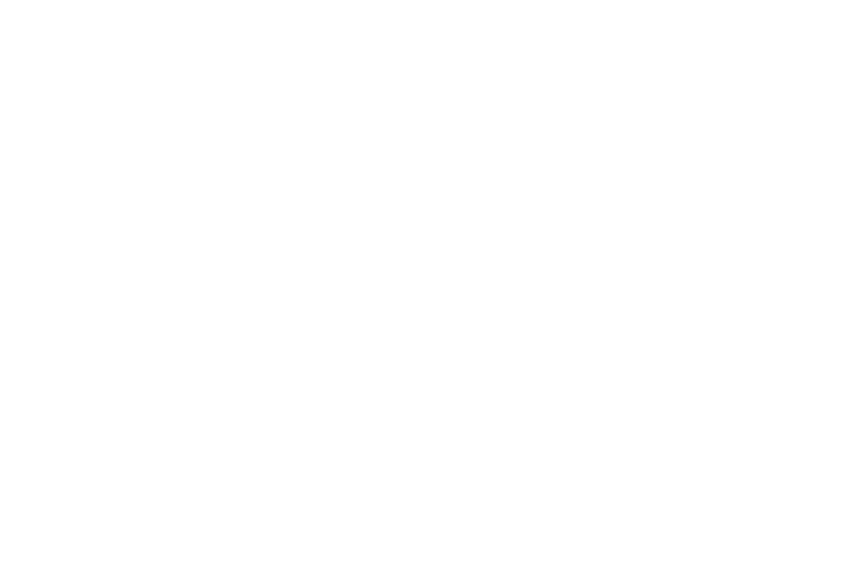

[[<Figure size 432x288 with 3 Axes>]]

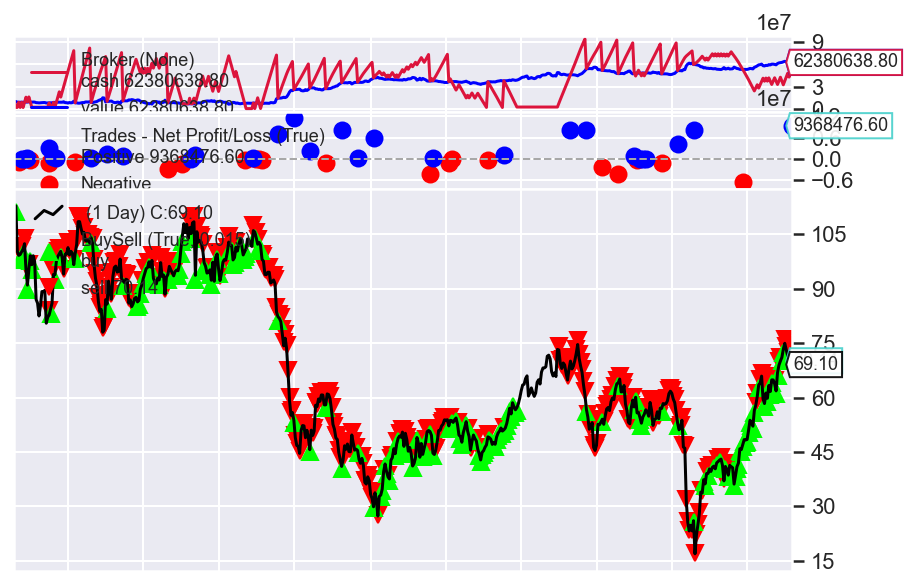

In [385]:
cerebro.plot(volume = False)

In [386]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 62380638.80


In [387]:
cerebro.broker.getcash()

62380638.80000008

In [388]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

PnL0.0
2011-04-21 Close, 112.29 ,position size 0
2011-04-21 BUY CREATE, 112.29 ,position size 0
2011-04-28 BUY EXECUTED, Price: 112.86, Cost: 7900200.00, Comm 7900.20 ,position size 70000
PnL-7900.199999999255
2011-04-28 Close, 112.86 ,position size 70000
2011-04-28 BUY CREATE, 112.86 ,position size 70000
2011-05-05 Order Canceled/Margin/Rejected ,position size 70000
PnL-884300.1999999993
2011-05-05 Close, 100.34 ,position size 70000
2011-05-05 SELL CREATE, 100.34 ,position size 70000
2011-05-12 SELL EXECUTED, Price: 99.23, Cost: 7900200.00, Comm 6946.10 ,position size 0
2011-05-12 OPERATION PROFIT, GROSS -954100.00, NET -968946.30 ,position size 0
PnL-968946.2999999989
2011-05-12 Close, 99.23 ,position size 0
2011-05-12 BUY CREATE, 99.23 ,position size 0
2011-05-19 BUY EXECUTED, Price: 99.47, Cost: 6962900.00, Comm 6962.90 ,position size 70000
PnL-975909.1999999993
2011-05-19 Close, 99.47 ,position size 70000
2011-05-19 SELL CREATE, 99.47 ,position size 70000
2011-05-26 SELL EXECUTED,

2013-09-19 SELL CREATE, 105.76 ,position size -70000
2013-09-26 SELL EXECUTED, Price: 102.86, Cost: -7200200.00, Comm 7200.20 ,position size -140000
PnL-1776935.3000000007
2013-09-26 Close, 102.86 ,position size -140000
2013-09-26 SELL CREATE, 102.86 ,position size -140000
2013-10-03 SELL EXECUTED, Price: 103.31, Cost: -7231700.00, Comm 7231.70 ,position size -210000
PnL-1847167.0
2013-10-03 Close, 103.31 ,position size -210000
2013-10-03 SELL CREATE, 103.31 ,position size -210000
2013-10-10 SELL EXECUTED, Price: 102.84, Cost: -7198800.00, Comm 7198.80 ,position size -280000
PnL-1755665.799999997
2013-10-10 Close, 102.84 ,position size -280000
2013-10-10 SELL CREATE, 102.84 ,position size -280000
2013-10-17 SELL EXECUTED, Price: 100.97, Cost: -7067900.00, Comm 7067.90 ,position size -350000
PnL-1239133.6999999955
2013-10-17 Close, 100.97 ,position size -350000
2013-10-17 BUY CREATE, 100.97 ,position size -350000
2013-10-24 BUY EXECUTED, Price: 97.23, Cost: -7220360.00, Comm 6806.10 ,po

2015-03-19 OPERATION PROFIT, GROSS 2450000.00, NET 2383696.00 ,position size 0
PnL18357168.90000002
2015-03-19 Close, 45.61 ,position size 0
2015-03-19 SELL CREATE, 45.61 ,position size 0
2015-03-26 SELL EXECUTED, Price: 51.00, Cost: -3570000.00, Comm 3570.00 ,position size -70000
PnL18353598.90000002
2015-03-26 Close, 51.00 ,position size -70000
2015-03-26 SELL CREATE, 51.00 ,position size -70000
2015-04-02 SELL EXECUTED, Price: 49.55, Cost: -3468500.00, Comm 3468.50 ,position size -140000
PnL18451630.40000002
2015-04-02 Close, 49.55 ,position size -140000
2015-04-02 SELL CREATE, 49.55 ,position size -140000
2015-04-09 SELL EXECUTED, Price: 50.75, Cost: -3552500.00, Comm 3552.50 ,position size -210000
PnL18280077.90000002
2015-04-09 Close, 50.75 ,position size -210000
2015-04-09 SELL CREATE, 50.75 ,position size -210000
2015-04-16 SELL EXECUTED, Price: 57.89, Cost: -4052300.00, Comm 4052.30 ,position size -280000
PnL16776625.600000024
2015-04-16 Close, 57.89 ,position size -280000
201

2017-03-02 SELL CREATE, 52.56 ,position size 140000
2017-03-09 SELL EXECUTED, Price: 49.62, Cost: 3764600.00, Comm 3473.40 ,position size 70000
PnL25954905.90000003
2017-03-09 Close, 49.62 ,position size 70000
2017-03-09 BUY CREATE, 49.62 ,position size 70000
2017-03-16 BUY EXECUTED, Price: 49.26, Cost: 3448200.00, Comm 3448.20 ,position size 140000
PnL25926257.700000033
2017-03-16 Close, 49.26 ,position size 140000
2017-03-16 BUY CREATE, 49.26 ,position size 140000
2017-03-23 BUY EXECUTED, Price: 47.67, Cost: 3336900.00, Comm 3336.90 ,position size 210000
PnL25700320.800000027
2017-03-23 Close, 47.67 ,position size 210000
2017-03-23 BUY CREATE, 47.67 ,position size 210000
2017-03-30 BUY EXECUTED, Price: 50.33, Cost: 3523100.00, Comm 3523.10 ,position size 280000
PnL26255397.700000033
2017-03-30 Close, 50.33 ,position size 280000
2017-03-30 BUY CREATE, 50.33 ,position size 280000
2017-04-06 BUY EXECUTED, Price: 51.74, Cost: 3621800.00, Comm 3621.80 ,position size 350000
PnL26646575.900

2018-10-04 SELL EXECUTED, Price: 74.63, Cost: -5224100.00, Comm 5224.10 ,position size -350000
PnL34472814.60000005
2018-10-04 Close, 74.63 ,position size -350000
2018-10-04 SELL CREATE, 74.63 ,position size -350000
2018-10-11 SELL EXECUTED, Price: 70.85, Cost: -4959500.00, Comm 4959.50 ,position size -420000
PnL35790855.10000005
2018-10-11 Close, 70.85 ,position size -420000
2018-10-11 SELL CREATE, 70.85 ,position size -420000
2018-10-18 SELL EXECUTED, Price: 68.71, Cost: -4809700.00, Comm 4809.70 ,position size -490000
PnL36684845.40000005
2018-10-18 Close, 68.71 ,position size -490000
2018-10-18 SELL CREATE, 68.71 ,position size -490000
2018-10-25 SELL EXECUTED, Price: 66.97, Cost: -4687900.00, Comm 4687.90 ,position size -560000
PnL37532757.500000045
2018-10-25 Close, 66.97 ,position size -560000
2018-10-25 SELL CREATE, 66.97 ,position size -560000
2018-11-01 SELL EXECUTED, Price: 63.54, Cost: -4447800.00, Comm 4447.80 ,position size -630000
PnL39449109.70000005
2018-11-01 Close, 6

2020-04-09 Close, 23.19 ,position size -700000
2020-04-16 BUY EXECUTED, Price: 26.02, Cost: -26399100.00, Comm 18214.00 ,position size 0
2020-04-16 OPERATION PROFIT, GROSS 8185100.00, NET 8140486.90 ,position size 0
PnL49524935.60000007
2020-04-16 Close, 26.02 ,position size 0
2020-04-16 SELL CREATE, 26.02 ,position size 0
2020-04-23 SELL EXECUTED, Price: 16.87, Cost: -1180900.00, Comm 1180.90 ,position size -70000
PnL49523754.70000007
2020-04-23 Close, 16.87 ,position size -70000
2020-04-23 SELL CREATE, 16.87 ,position size -70000
2020-04-30 SELL EXECUTED, Price: 22.00, Cost: -1540000.00, Comm 1540.00 ,position size -140000
PnL49163114.70000007
2020-04-30 Close, 22.00 ,position size -140000
2020-04-30 SELL CREATE, 22.00 ,position size -140000
2020-05-07 SELL EXECUTED, Price: 24.84, Cost: -1738800.00, Comm 1738.80 ,position size -210000
PnL48763775.90000007
2020-05-07 Close, 24.84 ,position size -210000
2020-05-07 SELL CREATE, 24.84 ,position size -210000
2020-05-14 SELL EXECUTED, Pric

In [389]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

<IPython.core.display.Javascript object>


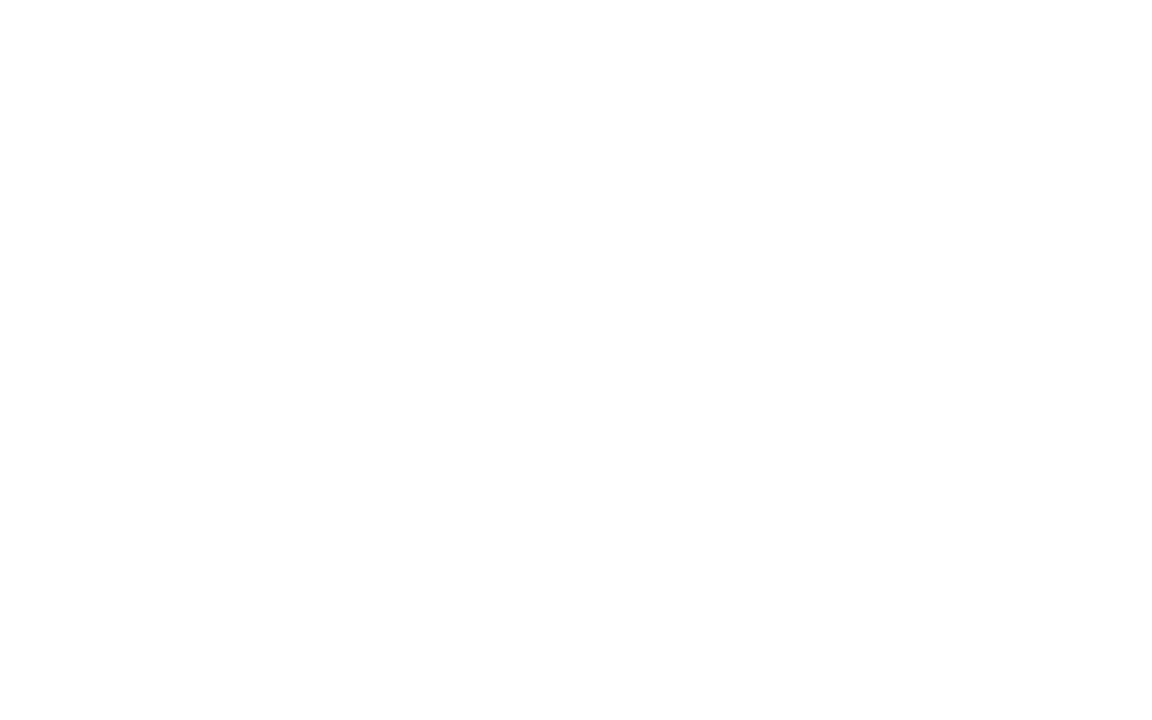

<IPython.core.display.Javascript object>


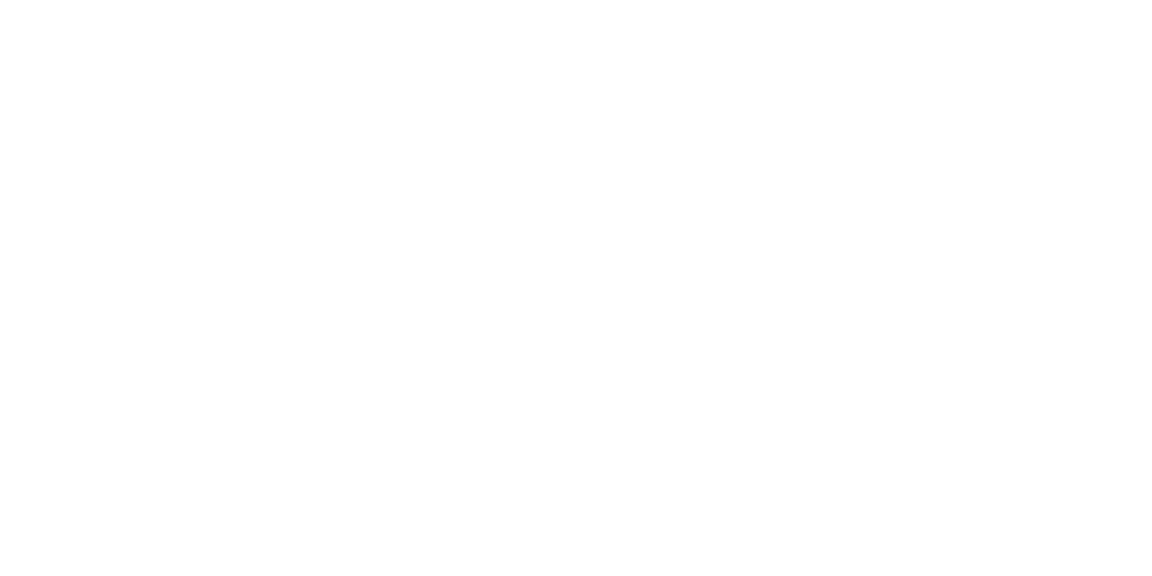

<IPython.core.display.Javascript object>


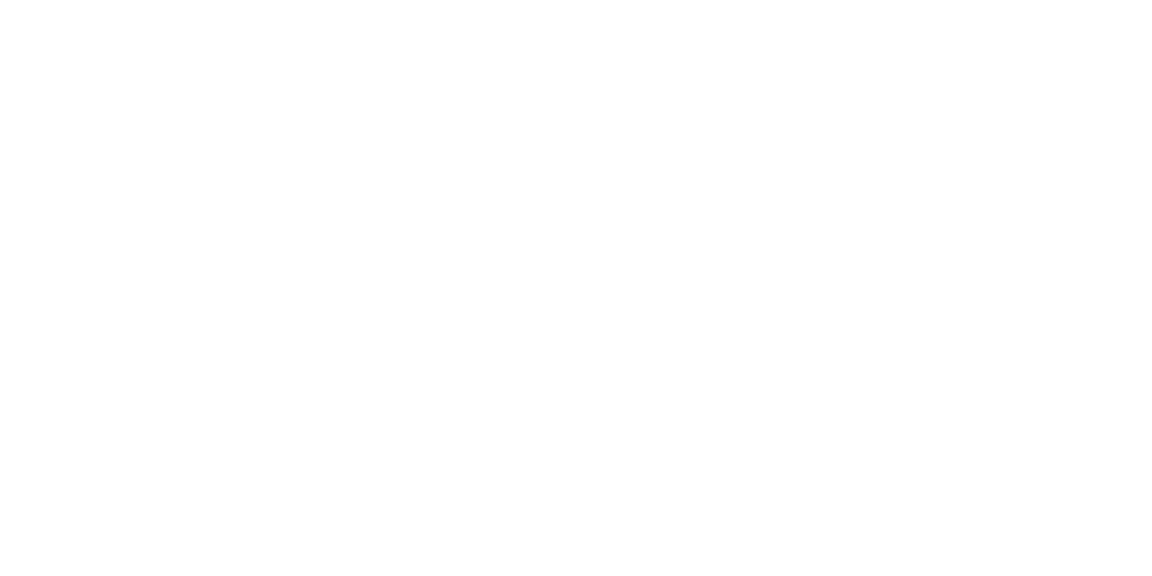

<IPython.core.display.Javascript object>


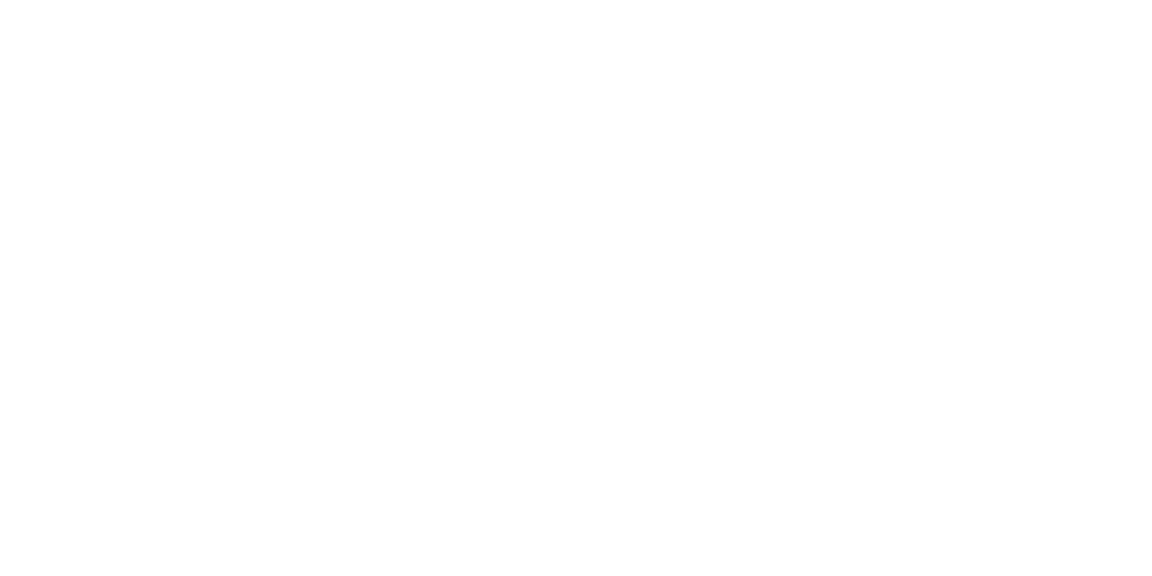

<IPython.core.display.Javascript object>


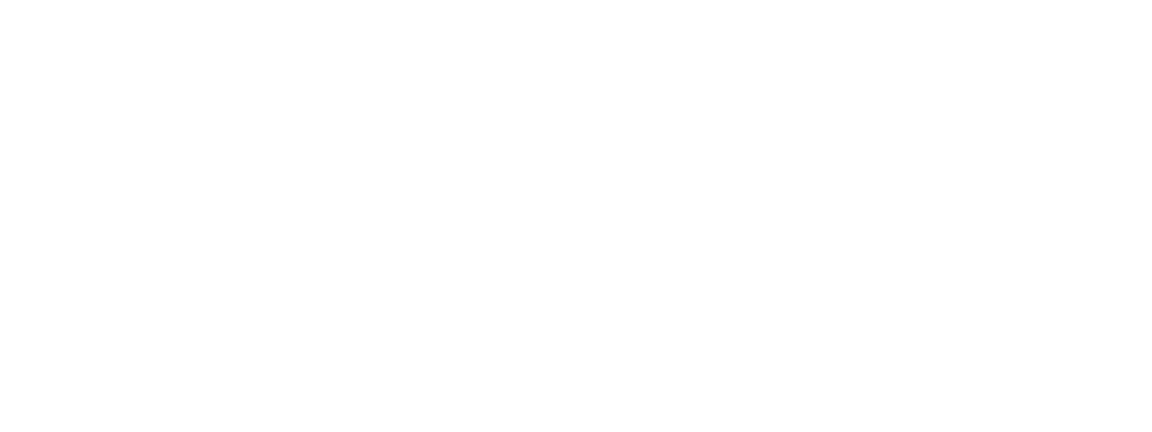

<IPython.core.display.Javascript object>


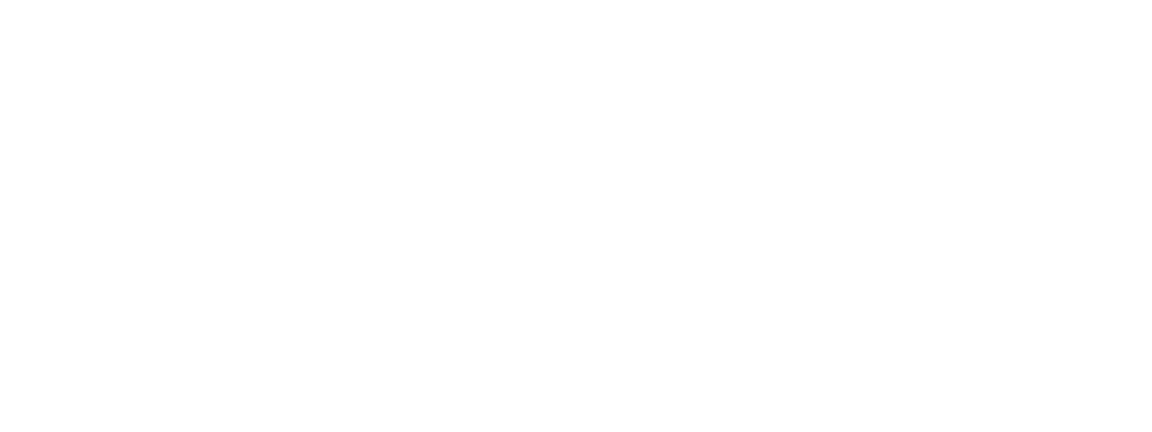

<IPython.core.display.Javascript object>


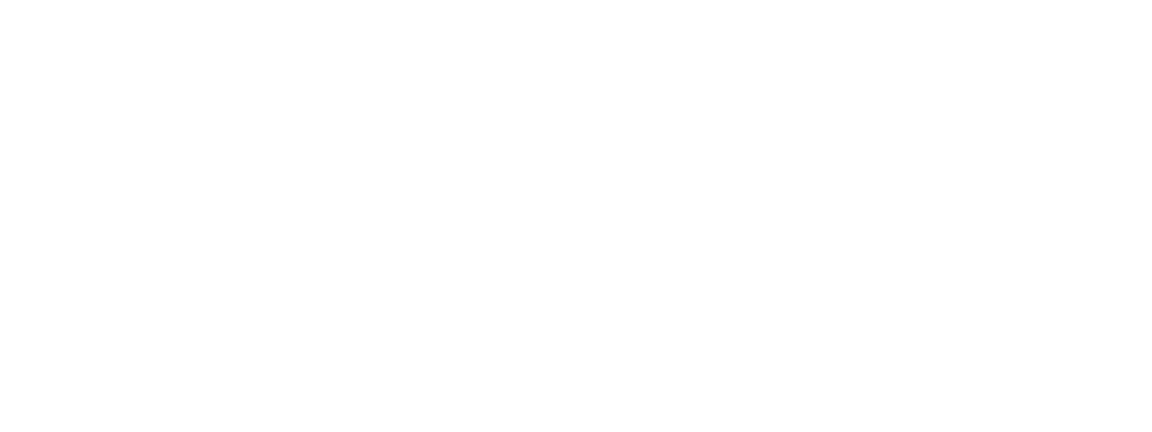

<IPython.core.display.Javascript object>


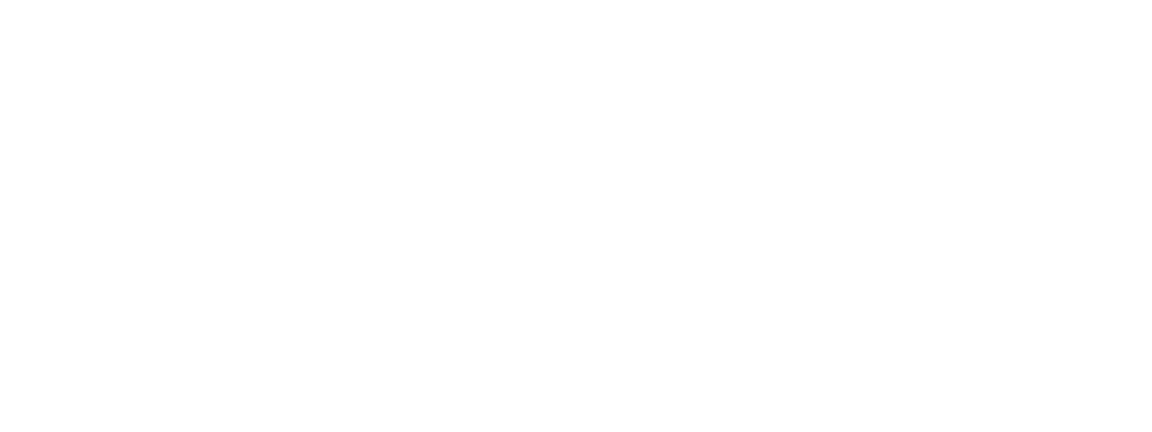

<IPython.core.display.Javascript object>


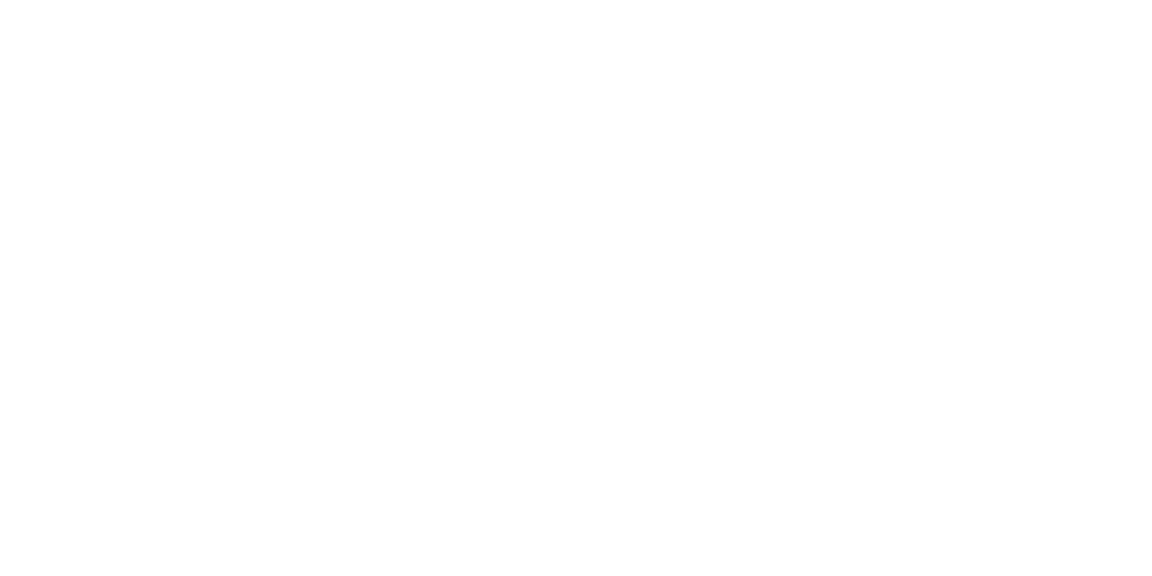

<IPython.core.display.Javascript object>


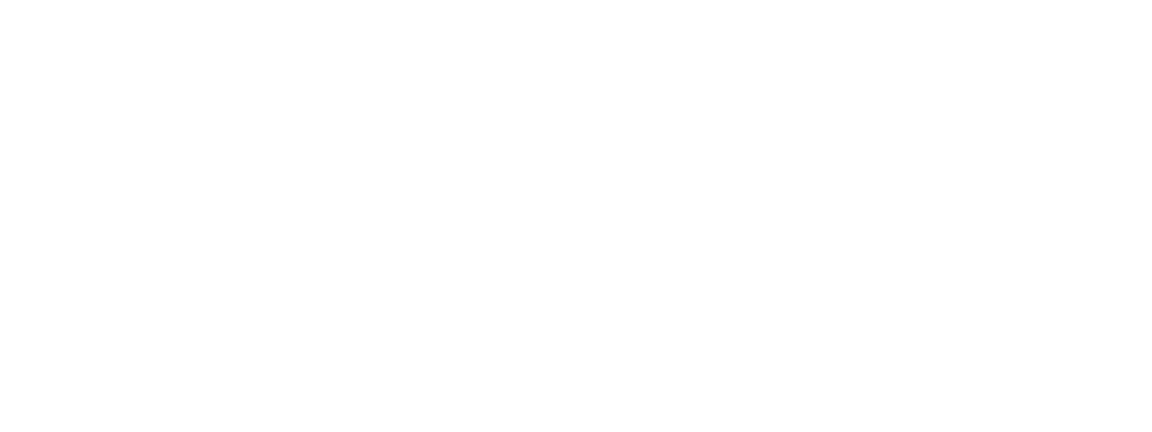

<IPython.core.display.Javascript object>


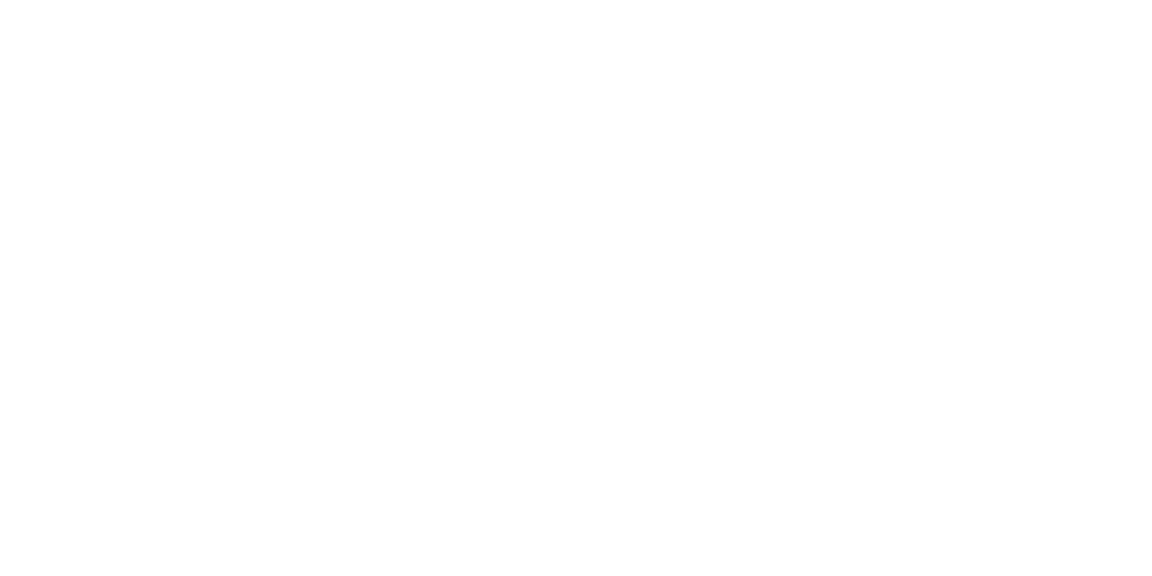

<IPython.core.display.Javascript object>


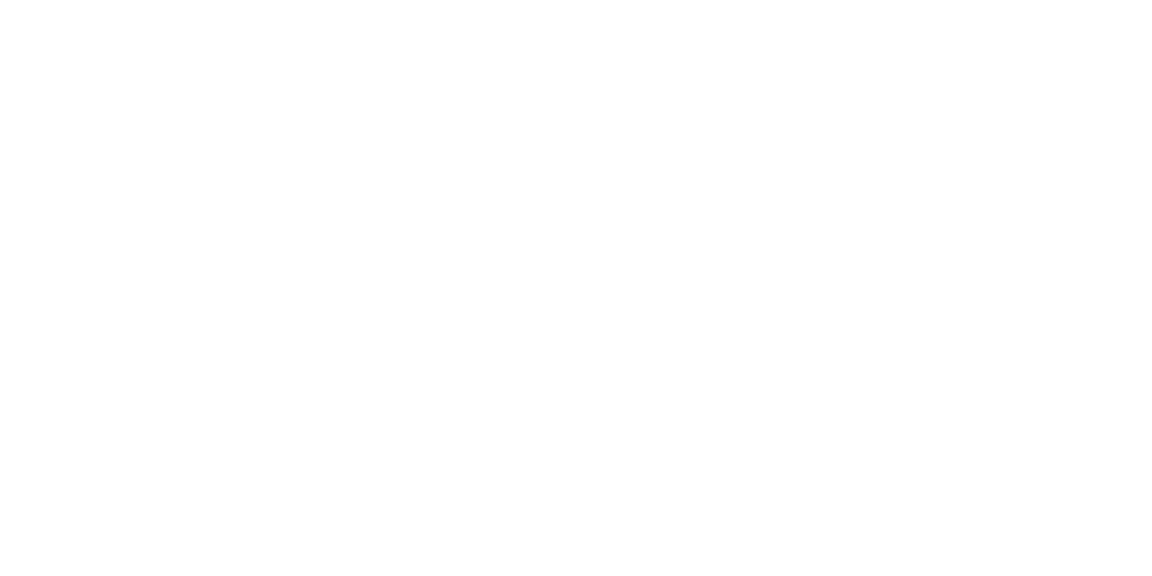

In [390]:
quantstats.reports.html(returns, output='stats.html')
